In [2]:
import numpy as np
from keras.datasets import boston_housing
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
import matplotlib.pyplot as plt

In [3]:
# load data 
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [6]:
# normalize data 
mean = train_data.mean(axis=0)
std  = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

In [7]:
# model architecture 
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [9]:
# k-fold validation 
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data    = np.concatenate([train_data[:i * num_val_samples], 
                                            train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], 
                                            train_targets[(i + 1) * num_val_samples:]], axis=0)
    model = build_model()
    model.fit(partial_train_data, 
              partial_train_targets,
              epochs=num_epochs, 
              batch_size=1, 
              verbose=0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [11]:
# mean score over k folds
print(all_scores)
print(np.mean(all_scores))

[2.100435495376587, 2.9318408966064453, 2.7072396278381348, 2.618344783782959]
2.5894652009010315


In [14]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data    = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]], axis=0)
    model = build_model()
    history = model.fit(partial_train_data, 
                        partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, 
                        batch_size=1, 
                        verbose=0)
    
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


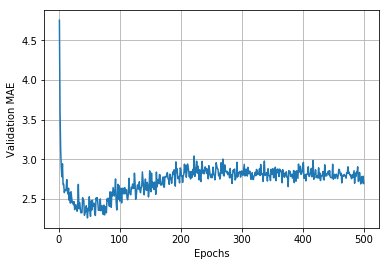

In [26]:
# mean MAE across folds, by epoch 
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.grid(which = 'both')
plt.show()

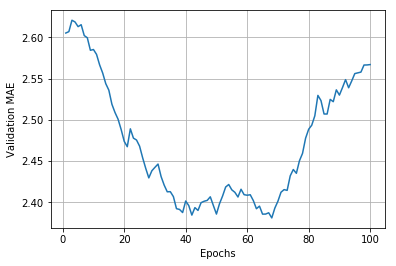

In [32]:
# smooth out the MAE 
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1)[:100], smooth_mae_history[:100])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.grid(which = 'both')
plt.show()

In [40]:
# retrain up to 65 epochs 
model = build_model()
model.fit(train_data, train_targets, epochs=65, batch_size=1, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 127us/step


In [41]:
test_mae_score # worse than val, but not by much

2.742422580718994